In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load all FIFA players' attributes

In [94]:
df = pd.read_csv("..\FIFA_Data.csv",index_col = 0, low_memory = False)

Briefly look at the data

In [95]:
df.head()

,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,...,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,PlayerPosition
Acceleration,,,,,,,,,,,,,,,,,,,,,
89,63,89,63,93,95,85,81,91,94,76,...,83,94,23,91,92,31,80,85,88,FWD
92,48,90,95,95,96,77,89,97,95,90,...,88,85,26,87,73,28,59,90,85,FWD
94,56,96,82,95,92,75,81,96,89,84,...,81,80,33,90,78,24,53,80,83,FWD
88,78,86,60,91,83,77,86,86,94,84,...,83,87,38,77,89,45,80,84,88,FWD
58,29,52,35,48,70,15,14,30,13,11,...,55,25,11,61,44,10,83,70,11,GK


Plot heatmap for the correlation matrix, positive value indicates positive correlated attributes and vice versa.

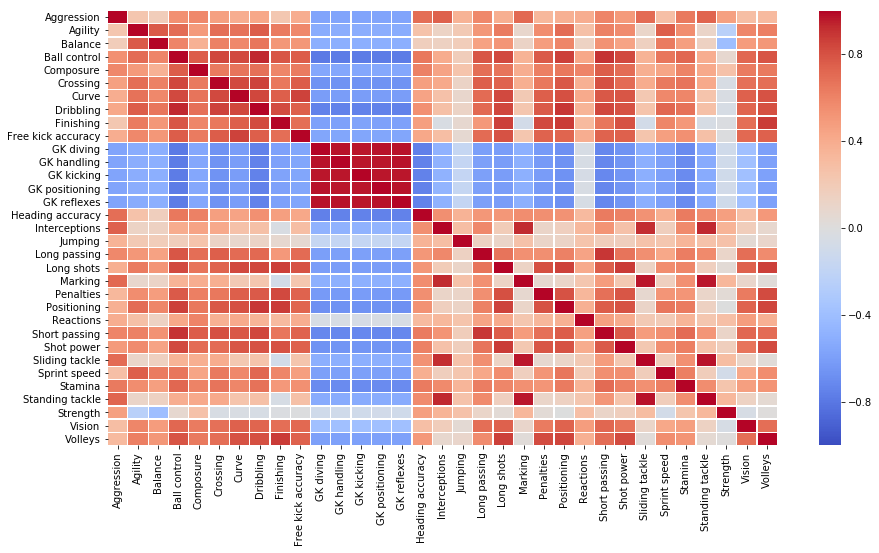

In [96]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),vmin=-1.0,vmax=1.0, linewidth=0.25, cmap='coolwarm')

We could observe that all GK skills are highly positive correlated while negatively correlated with other non-GK attributes.

Our goal is to simplify the data such that each attribute is nearly independent, e.g., compress all GK skills into one feature.

# Principal Component analysis

PCA is a common way to project high-dimensional data into smaller subspace by finding directions of maximal variance.

Firstly shift each feature to zero mean:

In [97]:
A = df.iloc[:,:-1] - df.iloc[:,:-1].mean()

Then applying SVD:

In [98]:
U, S, Vt = np.linalg.svd(A, full_matrices = False)
V = Vt.T
print("size of U:",U.shape)
print("size of sigma:",S.shape)
print("size of V:",V.shape)

size of U: (17981, 33)
size of sigma: (33,)
size of V: (33, 33)


In [99]:
variance = S**2
sum_var = sum(variance)
var_exp = [v/sum_var for v in variance]
cum_var = np.cumsum(var_exp)

Now, trying to visualize the variance explained by dominant components

Text(0, 0.5, '% variance')

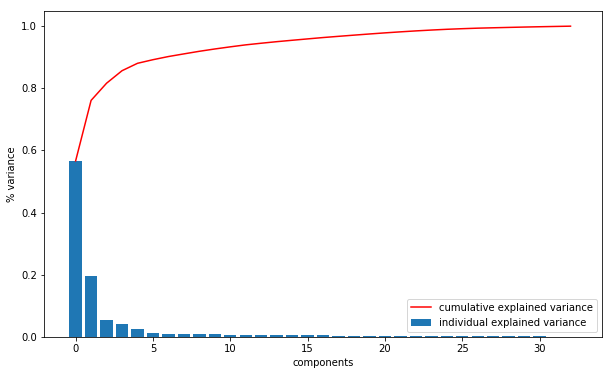

In [100]:
plt.figure(figsize=(10,6))
plt.bar(range(33),var_exp,label='individual explained variance')
plt.plot(range(33),cum_var,label='cumulative explained variance',color='r')
plt.legend(loc=0)
plt.xlabel("components")
plt.ylabel("% variance")

We could see that first two principal components have already carried over 70% information.

Now, we try to visualize original data by setting first two dominant components as X and Y axes.

Note that A*V = U*S and we can assume A to be transformation matrix and V to be original data points.

In [106]:
G = A@V[:,:2]
df["pc1"] = G[0]
df["pc2"] = G[1]

Ploting the scatter plot and indicating attributes direction on the new axes.

In [107]:
header = list(df.columns.values)

Each point represents one player and its color indicates its position, and silver arrows represent attributes.

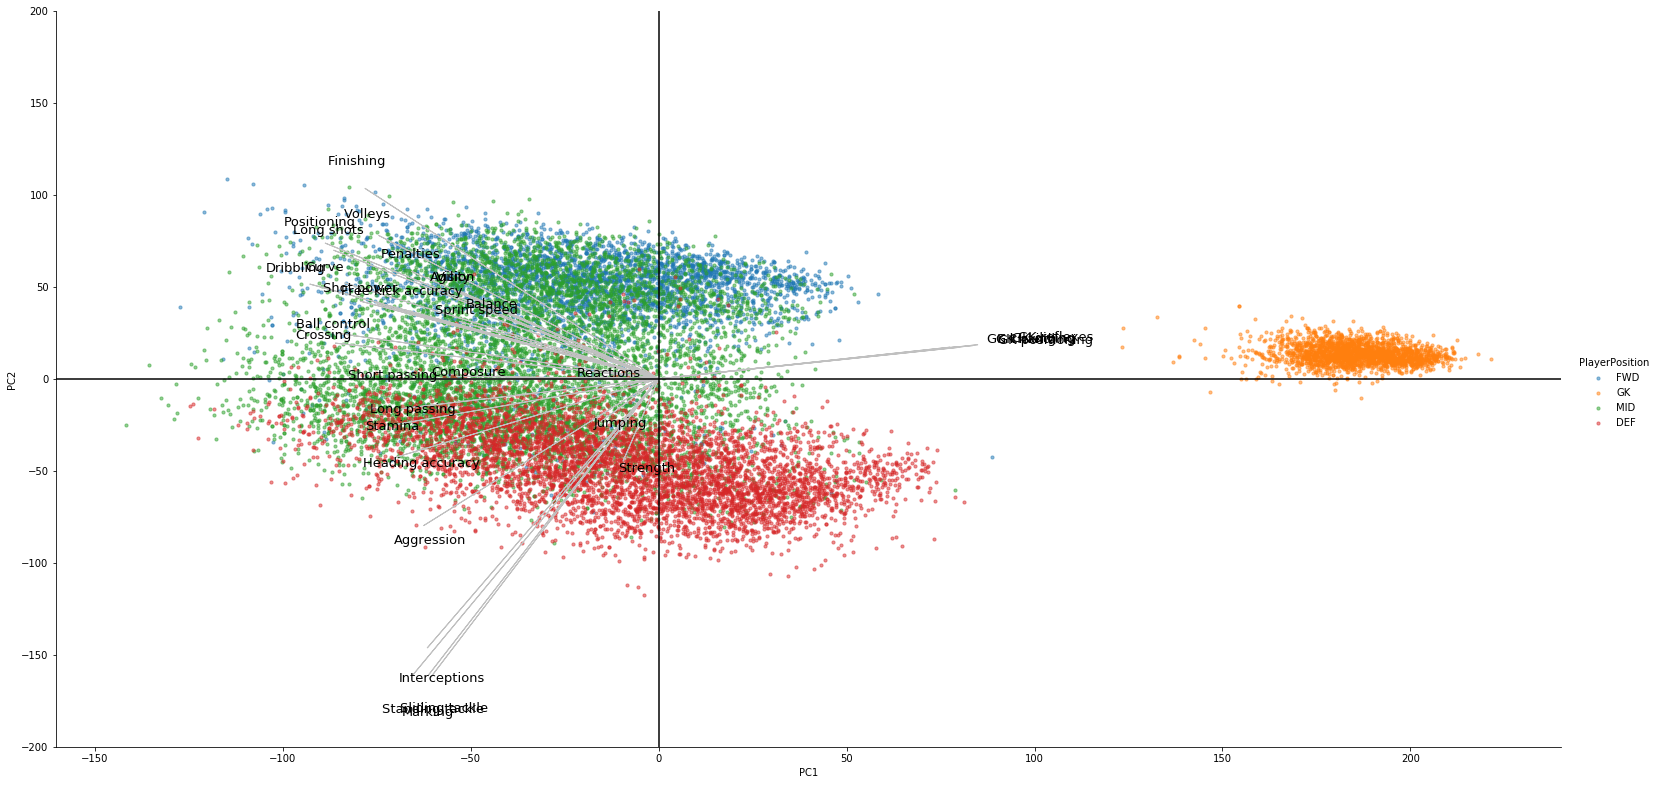

In [108]:
g = sns.lmplot(x = "pc1", y = "pc2", data = df, hue = "PlayerPosition", fit_reg=False, height=11, aspect=2, legend=True,
           scatter_kws={'s':10,'alpha':0.5})
ax = g.axes[0,0]
ax.axvline(x=0,color='k')
ax.axhline(y=0,color='k')
ax.set_ylim([-200,200])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

for i in range(33):
    ax.arrow(0,0,V[i,:][0]*400,V[i,:][1]*400,color='silver')
    ax.text(V[i,:][0]*450,V[i,:][1]*450,header[i],fontsize=13)

By just looking at the graph, we can say that PC1 determines how much goal keeping skills players possess.

Since goal keepers are a lot different than other players, we can drop them from data and repeat PCA for further information.

Remove unnecessary data from dataframe 

In [141]:
df2 = df.drop(["pc1","pc2",'GK diving',
 'GK handling',
 'GK kicking',
 'GK positioning',
 'GK reflexes'],1)
df2 = df2[df2.PlayerPosition != "GK"]

Repeat PCA

In [129]:
B = df2.iloc[:,:-1] - df2.iloc[:,:-1].mean()
u, s, vt = np.linalg.svd(B, full_matrices = False)
v = vt.T

In [130]:
variance = s**2
sum_var = sum(variance)
var_exp = [v/sum_var for v in variance]
cum_var = np.cumsum(var_exp)

Text(0, 0.5, '% variance')

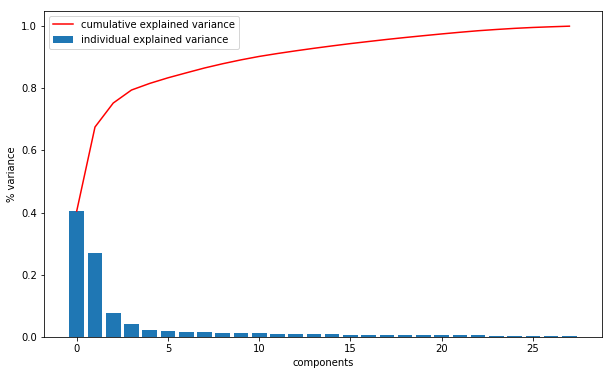

In [132]:
plt.figure(figsize=(10,6))
plt.bar(range(28),var_exp,label='individual explained variance')
plt.plot(range(28),cum_var,label='cumulative explained variance',color='r')
plt.legend(loc=0)
plt.xlabel("components")
plt.ylabel("% variance")

In [134]:
H = B@v[:,:2]
df2["pc1"] = H[0]
df2["pc2"] = H[1]
header2 = list(df2.columns.values)

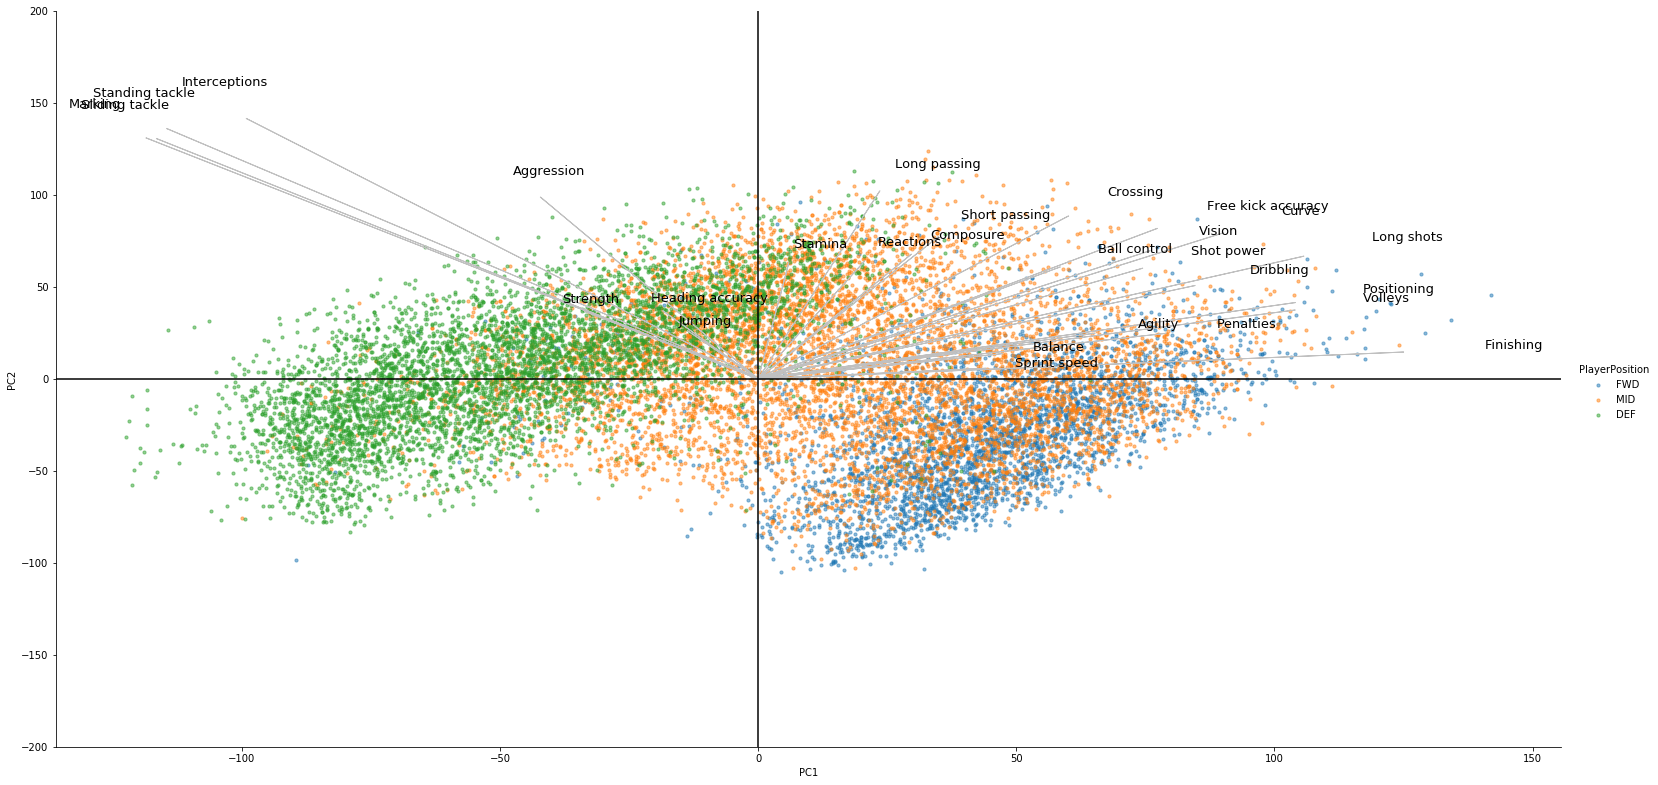

In [136]:
g = sns.lmplot(x = "pc1", y = "pc2", data = df2, hue = "PlayerPosition", fit_reg=False, height=11, aspect=2, legend=True,
           scatter_kws={'s':10,'alpha':0.5})
ax = g.axes[0,0]
ax.axvline(x=0,color='k')
ax.axhline(y=0,color='k')
ax.set_ylim([-200,200])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

for i in range(28):
    ax.arrow(0,0,v[i,:][0]*400,v[i,:][1]*400,color='silver')
    ax.text(v[i,:][0]*450,v[i,:][1]*450,header2[i],fontsize=13)

Now, we can see clearly that Defense players are highly correlated to those defense skills.
- interception
- standing tackle
- sliding tackle
- marking

While mid field and forward player share similar skills.
- short passing
- crossing
- vision
- ball control

And forward players possess offense skills.
- finishing
- sprint speed
- balance
- agility
- penalities